<a href="https://colab.research.google.com/github/brianmulyadi/Designing-Data-Products/blob/main/pass_bill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is the likelihood of a bill being passed in the Congress?

This notebook shows the process of deciding the model which shows the best fit for the congress data extracted from [ProPublica API](https://projects.propublica.org/api-docs/congress-api/).

The output of this exercise can contribute in creating a product that may be used by lobbyists, corporations, or the general public in predicting the likelihood of a bill being passed in the Congress.

We explore the following models in this exercise:
- Logistic Regression
- Decision Tree
- Random Forest

Thank you to [Calvin Tirell](https://github.com/calvintirrell) for advising us throughout the process.

In [32]:
# start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from datetime import datetime
from datetime import date

from sklearn.tree import DecisionTreeClassifier # import Decision Tree Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics # import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score # import necessary metrics
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv('drive/MyDrive/congress.csv', parse_dates=True, index_col=0, header=0)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13734 entries, 0 to 13733
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   policyArea         13666 non-null  object 
 1   issponsorPartyMaj  13734 non-null  int64  
 2   cosponsors         13734 non-null  int64  
 3   cosponsorsMaj      13734 non-null  float64
 4   billStatus         13734 non-null  int64  
 5   leadershipRole     13734 non-null  int64  
 6   dwNominate         13734 non-null  float64
 7   seniority          13734 non-null  int64  
 8   votesAgainstParty  13734 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 1.0+ MB


In [36]:
df.describe()

,issponsorPartyMaj,cosponsors,cosponsorsMaj,billStatus,leadershipRole,dwNominate,seniority,votesAgainstParty
count,13734.000000,13734.000000,1.373400e+04,13734.000000,13734.000000,13734.000000,13734.000000,13734.000000
mean,0.564948,16.565604,inf,0.101864,0.184651,0.011433,11.692879,4.588020
std,0.495782,35.382814,NaN,0.302480,0.388028,0.422774,9.469818,4.858642
min,0.000000,0.000000,-1.000000e+00,0.000000,0.000000,-0.702000,2.000000,0.000000
25%,0.000000,1.000000,0.000000e+00,0.000000,0.000000,-0.386000,4.000000,1.630000
50%,1.000000,4.000000,5.184566e-01,0.000000,0.000000,0.000000,8.000000,3.260000
75%,1.000000,16.000000,1.000000e+00,0.000000,0.000000,0.432000,16.000000,5.410000
max,1.000000,385.000000,inf,1.000000,1.000000,0.931000,54.000000,38.730000


### Understanding the data

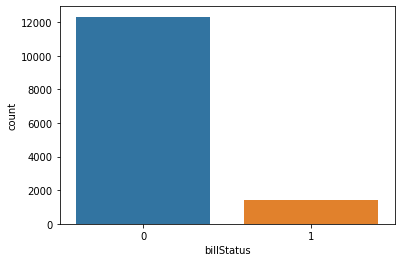

In [37]:
# understanding the proportion of passed bills compared to bills that did not pass the House
sns.countplot(x=df['billStatus'])

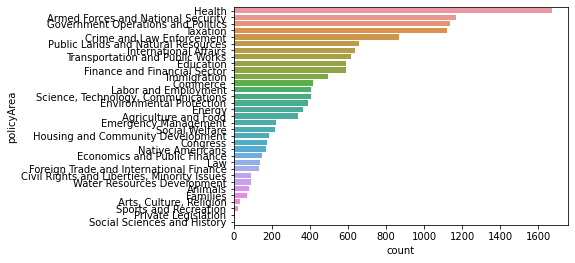

In [38]:
# list out all the policy areas and sort them by count
sns.countplot(y=df['policyArea'], order = df['policyArea'].value_counts().index)

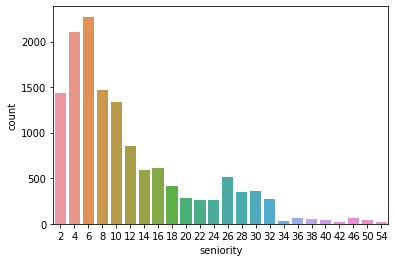

In [39]:
# the members of congress sorted by seniority (number of terms in congress)
sns.countplot(x=df['seniority'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


AxesSubplot(0.125,0.125;0.62x0.755)


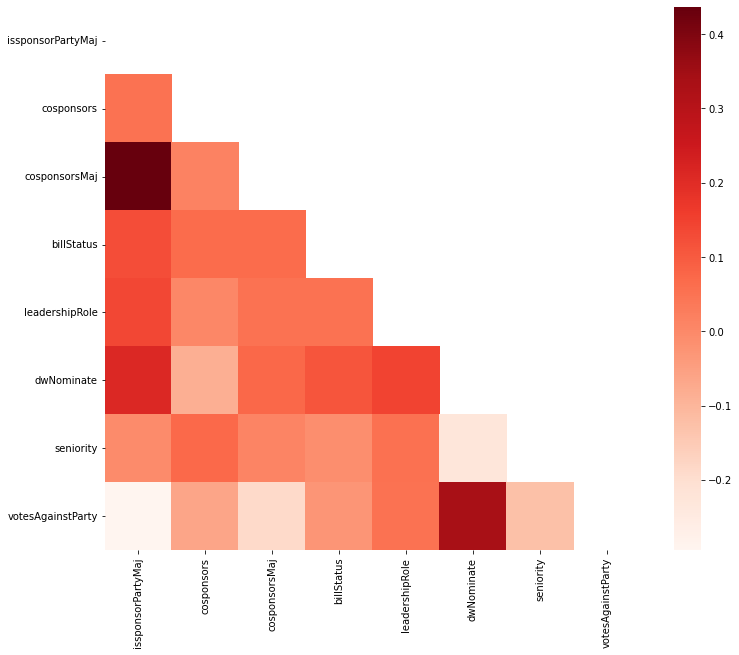

In [40]:
# calculate the correlations between the feature vectors
correlations = df.corr()
f, ax = plt.subplots(figsize = (12,10))

# 2 lines prevent the 'mirrored' half of the same data from showing up
mask = np.zeros_like(correlations, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

heatmap = sns.heatmap(correlations, cmap = 'Reds', mask = mask)
print(heatmap)

### Prepare data for creating the model

In [41]:
# create dummy variables for policy area
df['policyArea'] = df['policyArea'].fillna('Other')
df = pd.get_dummies(df,columns=['policyArea'])
df.head()

,issponsorPartyMaj,cosponsors,cosponsorsMaj,billStatus,leadershipRole,dwNominate,seniority,votesAgainstParty,policyArea_Agriculture and Food,policyArea_Animals,...,policyArea_Other,policyArea_Private Legislation,policyArea_Public Lands and Natural Resources,"policyArea_Science, Technology, Communications",policyArea_Social Sciences and History,policyArea_Social Welfare,policyArea_Sports and Recreation,policyArea_Taxation,policyArea_Transportation and Public Works,policyArea_Water Resources Development
0,1,24,1.000000,1,0,0.518,22,1.47,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,1.000000,1,0,0.590,14,4.74,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,16,1.000000,1,1,0.462,12,1.43,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,15,0.533333,1,1,0.374,18,3.49,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,25,0.960000,1,1,0.496,26,1.95,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# get list of feature columns
featureDf= df.loc[:, ~df.columns.isin(['billStatus'])]
featureDf.head()
feature_cols = featureDf.columns.values.tolist()
del featureDf
print(feature_cols)

['issponsorPartyMaj', 'cosponsors', 'cosponsorsMaj', 'leadershipRole', 'dwNominate', 'seniority', 'votesAgainstParty', 'policyArea_Agriculture and Food', 'policyArea_Animals', 'policyArea_Armed Forces and National Security', 'policyArea_Arts, Culture, Religion', 'policyArea_Civil Rights and Liberties, Minority Issues', 'policyArea_Commerce', 'policyArea_Congress', 'policyArea_Crime and Law Enforcement', 'policyArea_Economics and Public Finance', 'policyArea_Education', 'policyArea_Emergency Management', 'policyArea_Energy', 'policyArea_Environmental Protection', 'policyArea_Families', 'policyArea_Finance and Financial Sector', 'policyArea_Foreign Trade and International Finance', 'policyArea_Government Operations and Politics', 'policyArea_Health', 'policyArea_Housing and Community Development', 'policyArea_Immigration', 'policyArea_International Affairs', 'policyArea_Labor and Employment', 'policyArea_Law', 'policyArea_Native Americans', 'policyArea_Other', 'policyArea_Private Legisla

In [43]:
# replace NaN and inf in the dataset
df['billStatus'] = df['billStatus'].fillna(0)
df['billStatus'].replace([np.inf, -np.inf], 0, inplace = True)
df['cosponsorsMaj'].replace(np.inf, 0, inplace = True)

In [44]:
# split dataset to train and test
x = df[feature_cols]
y = df.billStatus

x_train, x_test, y_train, y_test = train_test_split(x,y, 
                                   test_size=0.25, 
                                   shuffle=True)

In [45]:
# get a rough idea of train test proportion
print("Train data:")
print(y_train.sum())
print(y_train.count())
print("Ratio of passed bills in training set:", round(y_train.sum()/y_train.count(),3))
print("------")
print("Test data:")
print(y_test.sum())
print(y_test.count())
print("Ratio of passed bills in test set:", round(y_train.sum()/y_train.count(),3))

Train data:
1013
10300
Ratio of passed bills in training set: 0.098
------
Test data:
386
3434
Ratio of passed bills in test set: 0.098


# Logistic Regression

In [46]:
# create logistic regression object
log = LogisticRegression(max_iter=1500)

# train model
log.fit(x_train, y_train)

# predict response for test dataset
y_pred = log.predict(x_test)

In [47]:
# create reusable function for metrics
def printMetrics(y_test, y_pred):
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test,y_pred))
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

printMetrics(y_test, y_pred)

auc = metrics.roc_auc_score(y_test, y_pred)
print("AUC score", auc)

Accuracy: 0.8858474082702388
Recall: 0.0051813471502590676
[[3040    8]
 [ 384    2]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3048
           1       0.20      0.01      0.01       386

    accuracy                           0.89      3434
   macro avg       0.54      0.50      0.47      3434
weighted avg       0.81      0.89      0.83      3434

AUC score 0.5012783376171243


In [48]:
# another method of charting roc/auc curve
# from sklearn.metrics import roc_curve
# from sklearn.metrics import RocCurveDisplay

# y_score = log.decision_function(x_test)

# fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=log.classes_[1])
# roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

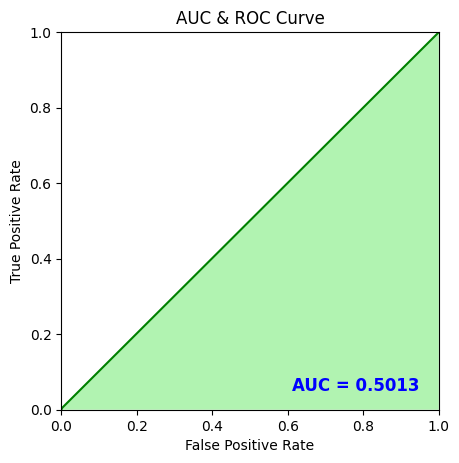

In [49]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [50]:
# optimize model using GridSearch

log_grid = {
    'max_iter' : [0, 1000, 5000, 10000]
}

log_reg = LogisticRegression(n_jobs = -1)
log_grid = GridSearchCV(estimator = log_reg, param_grid = log_grid, scoring = 'f1', cv = 10)
log_grid.fit(x_train, y_train)

print('Model name:', log_reg.__class__.__name__)
print()
print('Best parameters:', log_grid.best_params_)
print()
y_pred = log_grid.predict(x_test)
print('10 Fold Cross Validation Accuracy Score:', log_grid.score(x_test, y_test) * 100)
print()
print('Optimized F1-Score:', f1_score(y_test, y_pred) * 100)
print()
print('Classification report:')
print(classification_report(y_test, y_pred))
print()
print("ROC-AUC:", roc_auc_score(y_test, log_grid.predict_proba(x_test)[:,1]))

Model name: LogisticRegression

Best parameters: {'max_iter': 1000}

10 Fold Cross Validation Accuracy Score: 1.0101010101010102

Optimized F1-Score: 1.0101010101010102

Classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3048
           1       0.20      0.01      0.01       386

    accuracy                           0.89      3434
   macro avg       0.54      0.50      0.47      3434
weighted avg       0.81      0.89      0.83      3434


ROC-AUC: 0.7605071872492623


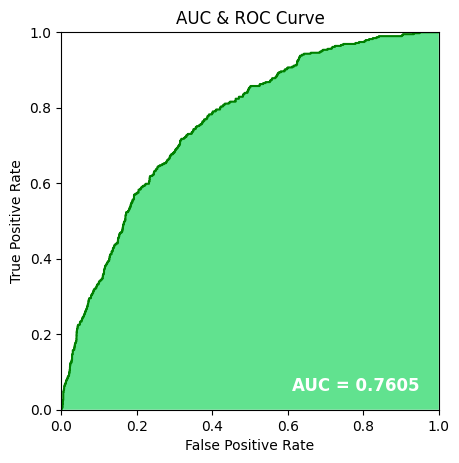

In [51]:
y_opt = log_grid.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_opt)
auc = metrics.roc_auc_score(y_test, y_opt)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='#1ED760', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='white')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Decision Tree

In [52]:
# create Decision Tree classifer object
clf = DecisionTreeClassifier()

# train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

# predict the response for test dataset
y_pred = clf.predict(x_test)

In [53]:
printMetrics(y_test, y_pred)
print("Max Depth:",clf.tree_.max_depth)
print("Node Count:",clf.tree_.node_count)

auc = metrics.roc_auc_score(y_test, y_pred)
print("AUC score:", auc)

Accuracy: 0.8459522422830519
Recall: 0.3290155440414508
[[2778  270]
 [ 259  127]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3048
           1       0.32      0.33      0.32       386

    accuracy                           0.85      3434
   macro avg       0.62      0.62      0.62      3434
weighted avg       0.85      0.85      0.85      3434

Max Depth: 35
Node Count: 2529
AUC score: 0.6202164334380483


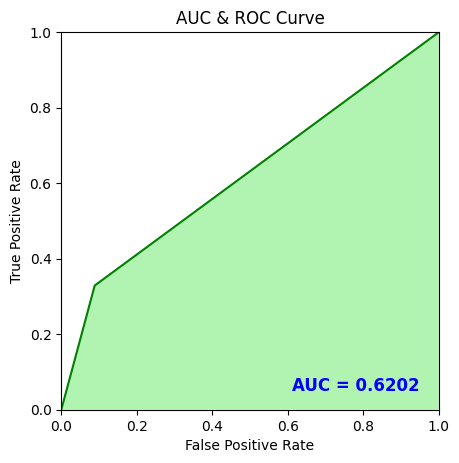

In [54]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [55]:
# optimize model using GridSearch

dt_grid = {
    'max_depth' : [5, 10, 15, 20]
}

dt_reg = DecisionTreeClassifier()

dt_grid = GridSearchCV(estimator = dt_reg, param_grid = dt_grid, scoring = 'f1', cv = 10)
dt_grid.fit(x_train, y_train)

print('Model name:', dt_reg.__class__.__name__)
print()
print('Best parameters:', dt_grid.best_params_)
print()
y_pred = dt_grid.predict(x_test)
print('10 Fold Cross Validation Accuracy Score:', dt_grid.score(x_test, y_test) * 100)
print()
print('Optimized F1-Score:', f1_score(y_test, y_pred) * 100)
print()
print('Classification report:')
print(classification_report(y_test, y_pred))
print()
print("ROC-AUC:", roc_auc_score(y_test, dt_grid.predict_proba(x_test)[:,1]))

Model name: DecisionTreeClassifier

Best parameters: {'max_depth': 20}

10 Fold Cross Validation Accuracy Score: 29.50354609929078

Optimized F1-Score: 29.50354609929078

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3048
           1       0.33      0.27      0.30       386

    accuracy                           0.86      3434
   macro avg       0.62      0.60      0.61      3434
weighted avg       0.84      0.86      0.85      3434


ROC-AUC: 0.6596230603946528


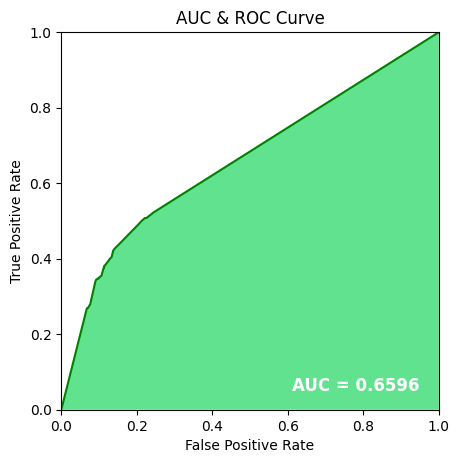

In [56]:
y_opt = dt_grid.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_opt)
auc = metrics.roc_auc_score(y_test, y_opt)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='#1ED760', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='white')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Random Forest

In [57]:
forest = RandomForestClassifier(n_estimators = 10)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

In [58]:
printMetrics(y_test, y_pred)

auc = metrics.roc_auc_score(y_test, y_pred)
print("AUC score:", auc)

Accuracy: 0.8867210250436809
Recall: 0.18393782383419688
[[2974   74]
 [ 315   71]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3048
           1       0.49      0.18      0.27       386

    accuracy                           0.89      3434
   macro avg       0.70      0.58      0.60      3434
weighted avg       0.86      0.89      0.86      3434

AUC score: 0.5798298043055499


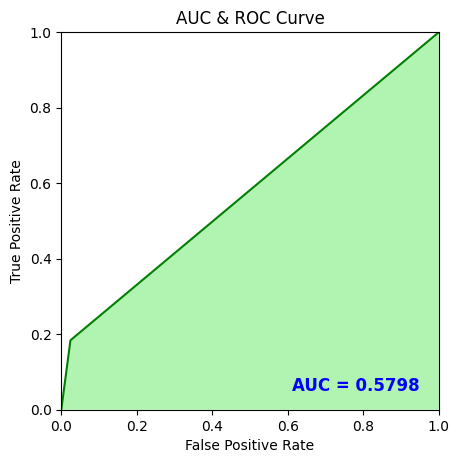

In [59]:
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [60]:
# optimize model using GridSearch

rf_class = RandomForestClassifier(n_jobs = -1)

rfc_grid = {
    'n_estimators' : [50, 100, 150],
    'max_depth' : [5, 10, 15, 20],
    'min_samples_split' : [6, 8, 10]
}

rfc_grid = GridSearchCV(estimator = rf_class, param_grid = rfc_grid, scoring = 'f1', cv = 10)
rfc_grid.fit(x_train, y_train)

print('Model name:', rf_class.__class__.__name__)
print()
print('Best parameters:', rfc_grid.best_params_)
print()
y_pred = rfc_grid.predict(x_test)
print('10 Fold Cross Validation Accuracy Score:', rfc_grid.score(x_test, y_test) * 100)
print()
print('Optimized F1-Score:', f1_score(y_test, y_pred) * 100)
print()
print('Classification report:')
print(classification_report(y_test, y_pred))
print()
print("ROC-AUC:", roc_auc_score(y_test, rfc_grid.predict_proba(x_test)[:,1]))

Model name: RandomForestClassifier

Best parameters: {'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 50}

10 Fold Cross Validation Accuracy Score: 22.41758241758242

Optimized F1-Score: 22.41758241758242

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3048
           1       0.74      0.13      0.22       386

    accuracy                           0.90      3434
   macro avg       0.82      0.56      0.58      3434
weighted avg       0.88      0.90      0.86      3434


ROC-AUC: 0.8183940373709763


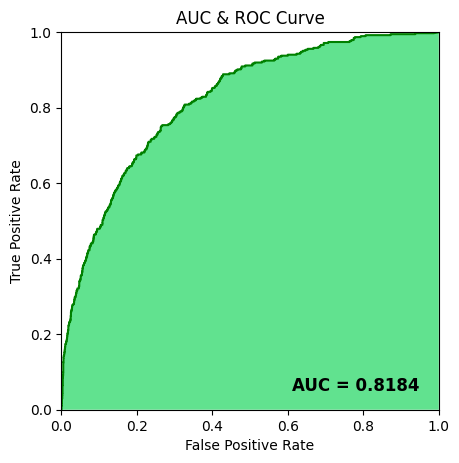

In [61]:
y_opt = rfc_grid.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_opt)
auc = metrics.roc_auc_score(y_test, y_opt)

plt.figure(figsize=(5, 5), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='#1ED760', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='black')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


### Pick the final model

Based on the scores above, we decided to pick the Random Forest model as it shows the highest ROC/AUC score. This model shows the best accuracy and recall rate given the dataset that we provide.

The following optimized hyperparameters will also be selected for the final model:
- Number of estimators: 150
- Max depth: 20
- Minimum samples split: 6

In [62]:
finalModel = RandomForestClassifier(n_estimators = 150, max_depth = 20, min_samples_split = 6)
finalModel.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=6, n_estimators=150)

Text(0, 0.5, 'Mean decrease in impurity')

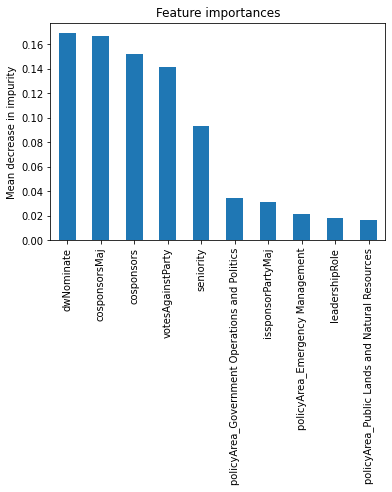

In [63]:
# create graph to show the feature importances

importances = finalModel.feature_importances_
forest_importances = pd.Series(importances, index=df.loc[:, df.columns != 'billStatus'].columns)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending = False)[0:10].plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")

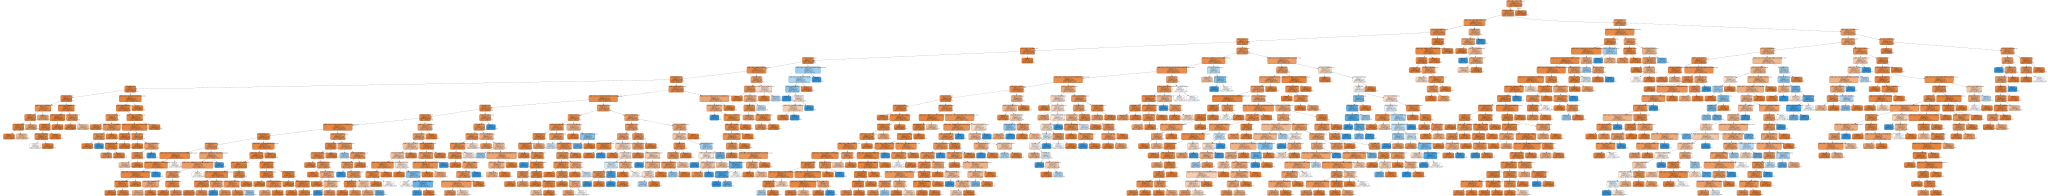

In [64]:
# create the visual of a sample tree from the selected Random Forest model

fn = x.columns
cn = ['Not Passed', 'Passed']

# fig, axes = plt.subplots(dpi=600)
# tree.plot_tree(finalModel.estimators_[0], feature_names = fn, 
#                class_names = cn, filled = True);

import graphviz

dot_data = tree.export_graphviz(finalModel.estimators_[0], 
                  feature_names=fn,  
                  class_names=cn,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph